# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

encoder = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/label_encoders.pkl')

Mounted at /content/drive


# **Modelo con no normalizados**


In [2]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
df.info()
df = df.sample(n=40000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  int64  
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  int64  
 5   conducta        492988 non-null  int64  
 6   modalidad       492988 non-null  int64  
 7   arma_medio      492988 non-null  int64  
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  int64  
 10  categoria_bien  492988 non-null  int64  
 11  día             492988 non-null  int64  
 12  mes             492988 non-null  int64  
 13  zona            492988 non-null  int64  
 14  rango_hora      492988 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 56.4 MB


In [ ]:
# Encontrar valor optimo para min_cluster_size
# ==============================================================================
min_sizes = range(5, 101, 5)
n_clusters = []

for size in min_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    print(f"min_cluster_size: {size}")
    clusterer.fit_predict(df.drop(columns=['latitud', 'longitud']))  # X es tu matriz de datos
    labels = clusterer.labels_
    n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))

plt.plot(min_sizes, n_clusters, marker='o')
plt.xlabel("min_cluster_size")
plt.ylabel("Número de clústers detectados")
plt.title("Optimización de min_cluster_size para HDBSCAN")
plt.grid(True)
plt.show()

In [4]:
# Modelado
# ==============================================================================

# HDBscan
dbscan = hdbscan.HDBSCAN(min_cluster_size=80)
df['cluster'] = dbscan.fit_predict(df.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud   longitud      sexo       edad  estado_civil  conducta  \
cluster                                                                     
-1       6.229122 -75.556676  0.333333  41.037037      0.629630  2.666667   
 0       6.248475 -75.575962  0.371816  34.314343      0.625976  2.526465   
 1       6.239535 -75.624886  0.320312  32.796875      0.507812  3.335938   

         modalidad  arma_medio  codigo_comuna     lugar  categoria_bien  \
cluster                                                                   
-1        0.592593    0.444444      83.333333  0.296296        0.740741   
 0        0.484001    0.508847      10.322851  0.468942        0.493763   
 1        0.375000    0.585938      69.843750  0.257812        0.976562   

               día       mes      zona  rango_hora  
cluster                                             
-1       17.666667  6.592593  0.000000    1.592593  
 0       15.604543  6.723905  1.055590    1.644397  
 1   

In [12]:
# visualizacion
# ==============================================================================


df_dots = df[["latitud", "longitud", "cluster"]]
df_dots = df_dots[df_dots["cluster"] != -1]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('Pastel1', num_clusters)
cluster_colors = {
    0: "#66c2ff",  # Azul
    1: "#8c564b",  # cafe
}

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
# cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)


# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Volver a valores originales para analisis
# ==============================================================================
var = df.columns.to_list()
var.remove('cluster')
cluster_summary = df.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,-1,6.172550,-75.656091,Hombre,56,soltero,Hurto a persona,violentos,Con_Arma,90,exteriores,alto_valor,26,5,Centro,Tarde,27
1,0,6.249775,-75.568542,Hombre,32,soltero,Hurto a persona,no_violentos,Sin_arma,10,exteriores,alto_valor,2,8,Centro,Tarde,39845
2,1,6.178621,-75.658100,Hombre,32,soltero,Hurto a persona,no_violentos,Sin_arma,60,exteriores,alto_valor,27,12,Centro,Noche,128


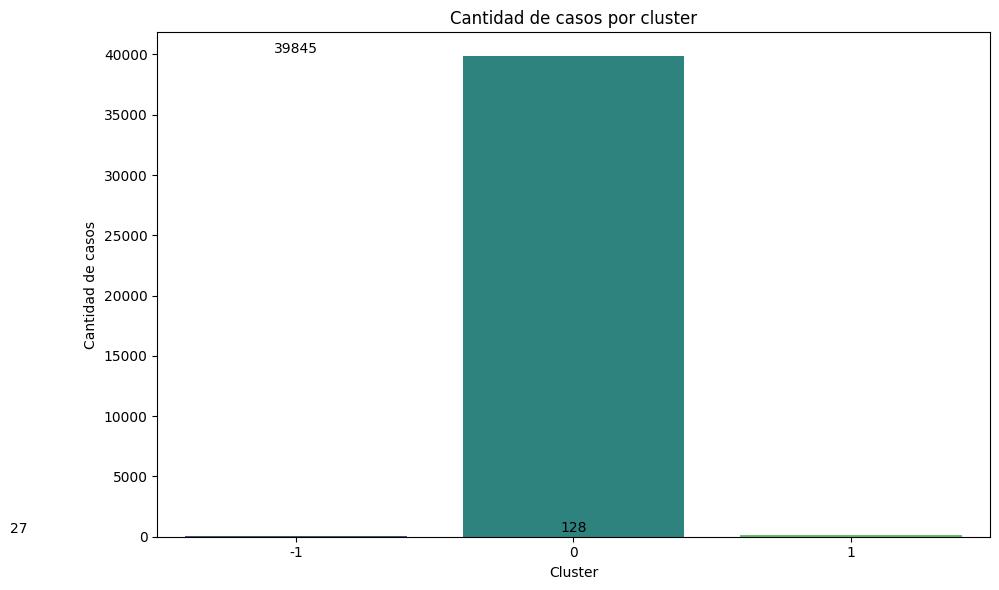

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 10, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Modelo con normalizados**


In [ ]:
df_norm = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')
scaler = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/standard_scaler.pkl')
df_norm.info()
df_norm = df_norm.sample(n=25000, random_state=42)
columns = df_norm.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  float64
 3   edad            492988 non-null  float64
 4   estado_civil    492988 non-null  float64
 5   conducta        492988 non-null  float64
 6   modalidad       492988 non-null  float64
 7   arma_medio      492988 non-null  float64
 8   codigo_comuna   492988 non-null  float64
 9   lugar           492988 non-null  float64
 10  categoria_bien  492988 non-null  float64
 11  día             492988 non-null  float64
 12  mes             492988 non-null  float64
 13  zona            492988 non-null  float64
 14  rango_hora      492988 non-null  float64
dtypes: float64(15)
memory usage: 56.4 MB


min_cluster_size: 50
min_cluster_size: 65
min_cluster_size: 80
min_cluster_size: 95
min_cluster_size: 110
min_cluster_size: 125
min_cluster_size: 140


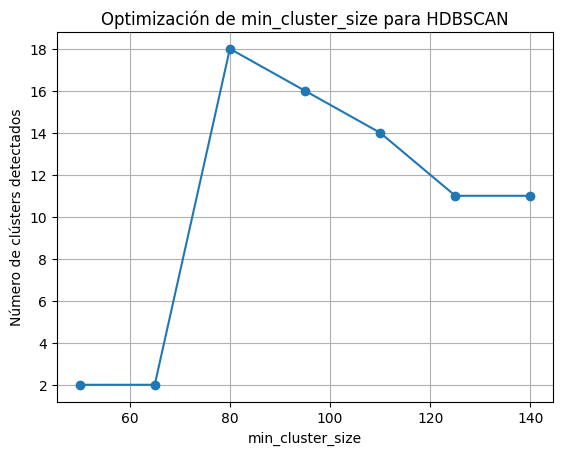

In [ ]:
# Encontrar valor optimo para min_cluster_size
# ==============================================================================
min_sizes = range(50, 150, 15)
n_clusters = []

for size in min_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    print(f"min_cluster_size: {size}")
    clusterer.fit_predict(df_norm.drop(columns=['latitud', 'longitud']))  # X es tu matriz de datos
    labels = clusterer.labels_
    n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))

plt.plot(min_sizes, n_clusters, marker='o')
plt.xlabel("min_cluster_size")
plt.ylabel("Número de clústers detectados")
plt.title("Optimización de min_cluster_size para HDBSCAN")
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster

dbscan = hdbscan.HDBSCAN(min_cluster_size=125)

df_norm['cluster'] = dbscan.fit_predict(df_norm.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df_norm.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud  longitud      sexo      edad  estado_civil  conducta  \
cluster                                                                   
-1      -0.002382 -0.003304  0.054138  0.129214     -0.127661  0.086464   
 0       0.275773  0.003197 -0.767655 -0.566420      0.405853  1.852783   
 1      -0.181241  0.002081  1.302668  0.168310     -1.287774 -0.464988   
 2       0.135996  0.000702 -0.767655  0.230802     -1.287774 -0.478131   
 3      -0.072259  0.004482 -0.767655  0.264505     -1.287774 -0.576633   
 4       0.296356  0.003137 -0.767655 -0.711111      0.776534  1.957277   
 5      -0.053766  0.007424  1.302668 -0.555663      0.776534 -0.468583   
 6      -0.152593  0.000239  1.302668 -0.426314      0.776534 -0.478213   
 7      -0.109881 -0.003448 -0.767655 -0.410655      0.776534 -0.478131   
 8      -0.146297  0.000519 -0.767655 -0.444498      0.776534 -0.578428   
 9       0.026455 -0.002976 -0.767655 -0.632853      0.776534 -0.537247   
 10 

In [ ]:
# visualizacion
# ==============================================================================

df_dots = df_norm.copy()


df_dots[columns]  = scaler.inverse_transform(df_dots[columns])
df_dots = df_dots[df_dots["cluster"] != -1]

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)


# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = df_norm.columns.to_list()
var.remove('cluster')

df_norm[var]  = scaler.inverse_transform(df_norm[var])

cluster_summary = df_norm.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_norm.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,-1,6.263426,-75.596287,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,exteriores,alto_valor,1.0,11.0,Centro,Tarde,18625
1,0,6.223348,-75.597647,Hombre,32.0,soltero,Hurto de moto,violentos,Con_Arma,10.0,exteriores,vehiculos,11.0,5.0,Centro,Noche,323
2,1,6.235187,-75.574366,Mujer,32.0,en_relacion,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,9.0,8.0,Centro,Mañana,213
3,2,6.249775,-75.568542,Hombre,32.0,en_relacion,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,10.0,6.0,Centro,Noche,697
4,3,6.234310,-75.602566,Hombre,32.0,en_relacion,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,19.0,8.0,Centro,Mañana,238
5,4,6.234921,-75.602566,Hombre,25.0,soltero,Hurto de moto,no_violentos,Sin_arma,9.0,exteriores,vehiculos,8.0,5.0,Centro,Noche,372
6,5,6.258499,-75.586163,Mujer,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,15.0,8.0,Centro,Noche,618
7,6,6.189340,-75.615558,Mujer,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,19.0,8.0,Centro,Mañana,982
8,7,6.245890,-75.574570,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,exteriores,alto_valor,17.0,9.0,Centro,Noche,246
9,8,6.225670,-75.600011,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,11.0,8.0,Centro,Mañana,746


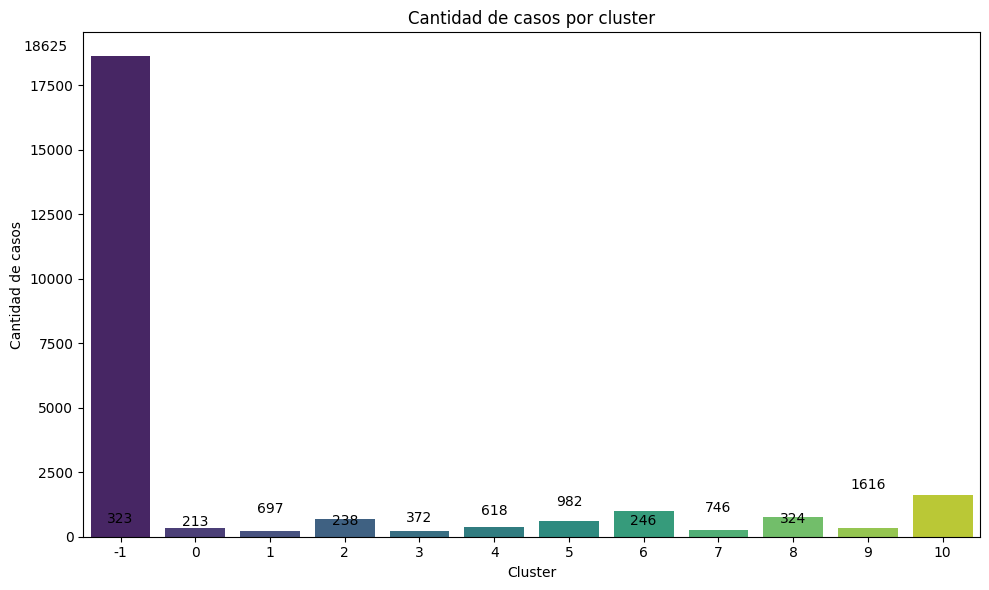

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Reduccion de dimensionalidad**

In [ ]:
df_reduc = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')

df_reduc = df_reduc.sample(n=25000, random_state=42)
columns = df_reduc.columns

In [ ]:
# Kernel pca
# ==============================================================================

X = df_reduc.values


kernel_pca = KernelPCA(
    n_components=5, kernel="rbf", gamma=0.1
)
X_test_kernel_pca = kernel_pca.fit_transform(df_reduc.drop(columns=['latitud', 'longitud']).values)

# Crear DataFrame de los componentes reducidos
df_kernel_pca = pd.DataFrame(
    X_test_kernel_pca,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    index=df_reduc.iloc[X_test_kernel_pca.shape[0]*-1:].index
)

# Crear DataFrame original de test
df_test_original = pd.DataFrame(X, columns=df_reduc.columns)

# Concatenar
df_combined = pd.concat([df_test_original.reset_index(drop=True), df_kernel_pca.reset_index(drop=True)], axis=1)

df_combined.head()



,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,PC1,PC2,PC3,PC4,PC5
0,1.136700,0.005946,1.302668,-0.215400,0.776534,-1.263604,1.031051,-1.013972,-1.005474,1.069119,0.613005,-1.083053,0.374026,-0.545270,-0.599263,0.118560,-0.146271,-0.037458,0.168004,-0.187978
1,1.524584,0.008360,1.302668,0.063861,0.776534,-0.437851,1.031051,-1.013972,-0.824828,-0.935349,-0.600282,1.636618,-1.650185,1.512197,-1.527258,0.121221,0.026946,0.007465,0.176517,-0.218514
2,-0.580780,0.103102,-0.767655,0.436207,-1.287774,1.213655,-0.969885,0.986220,-0.282890,-0.935349,1.826292,-1.083053,-0.782666,-0.545270,0.328733,-0.178197,0.430249,0.010349,-0.082584,0.186905
3,-1.109915,0.013558,1.302668,-0.215400,-1.287774,-1.263604,1.031051,-1.013972,0.620340,1.069119,0.613005,-1.309693,0.663199,-0.545270,-0.599263,0.071484,-0.067326,0.211036,0.115094,-0.140413
4,0.035527,0.064806,-0.767655,-0.122313,-1.287774,1.213655,-0.969885,0.986220,-0.463536,1.069119,1.826292,-1.536332,-0.204320,-0.545270,-1.527258,-0.219842,0.283205,0.010439,-0.119289,-0.065539


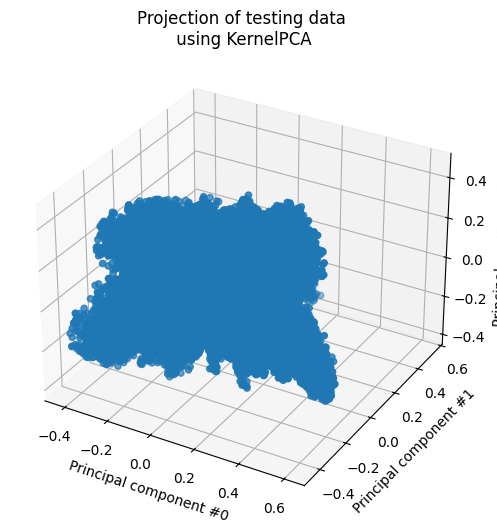

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    X_test_kernel_pca[:, 0],
    X_test_kernel_pca[:, 1],
    X_test_kernel_pca[:, 2],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

min_cluster_size: 40
min_cluster_size: 55
min_cluster_size: 70
min_cluster_size: 85
min_cluster_size: 100
min_cluster_size: 115
min_cluster_size: 130
min_cluster_size: 145
min_cluster_size: 160
min_cluster_size: 175
min_cluster_size: 190
min_cluster_size: 205
min_cluster_size: 220
min_cluster_size: 235


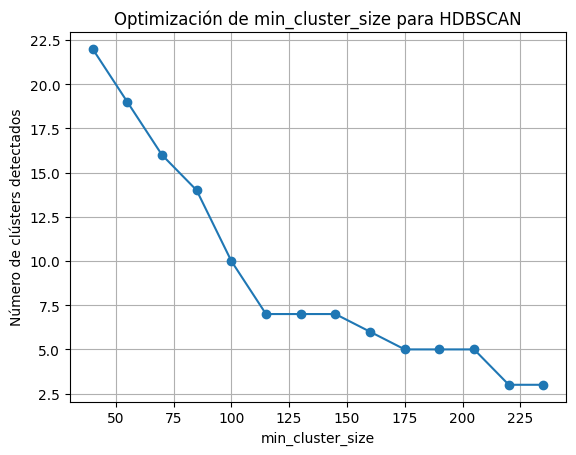

In [ ]:
# Encontrar valor optimo para min_cluster_size
# ==============================================================================
min_sizes = range(40, 250, 15)
n_clusters = []
df_kernel = pd.DataFrame(X_test_kernel_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

for size in min_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    print(f"min_cluster_size: {size}")
    clusterer.fit_predict(df_kernel)  # X es tu matriz de datos
    labels = clusterer.labels_
    n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))

plt.plot(min_sizes, n_clusters, marker='o')
plt.xlabel("min_cluster_size")
plt.ylabel("Número de clústers detectados")
plt.title("Optimización de min_cluster_size para HDBSCAN")
plt.grid(True)
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster
dbscan = hdbscan.HDBSCAN(min_cluster_size=205)
df_combined['cluster'] = dbscan.fit_predict(df_kernel)

# Análisis de los clusters
cluster_summary = df_combined.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud  longitud      sexo      edad  estado_civil  conducta  \
cluster                                                                   
-1      -0.052365 -0.002475  0.133715  0.091334     -0.069956 -0.284546   
 0       0.040317  0.004768 -0.767655 -0.674184      0.775129 -0.482790   
 1      -0.063437  0.000620 -0.767655 -0.454766      0.776534 -0.633533   
 2       0.186542  0.002610 -0.767655  0.055747     -1.278305 -0.513608   
 3      -0.057391  0.001661  1.302668 -0.562938      0.776534 -0.503685   
 4       0.187423 -0.001798 -0.318745 -0.050436     -0.075126  1.563817   

         modalidad  arma_medio  codigo_comuna     lugar  categoria_bien  \
cluster                                                                   
-1        0.026139   -0.009323      -0.002654  0.071114       -0.242802   
 0        1.031051   -1.013972      -0.086760 -0.676268       -0.579647   
 1       -0.963159    0.959327      -0.043344  0.823193       -0.498325   
 2 

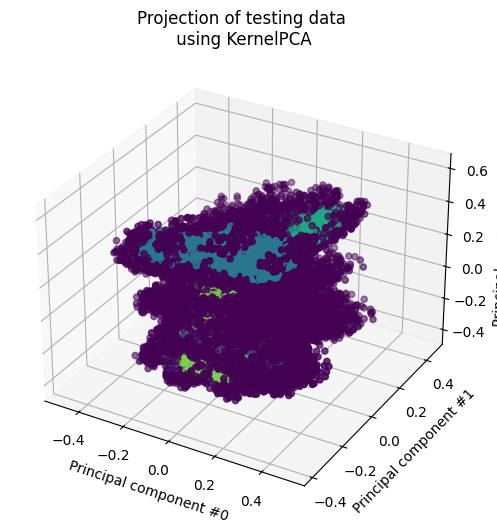

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    df_combined['PC5'],
    df_combined['PC3'],
    df_combined['PC1'],
    c = df_combined['cluster'],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

In [ ]:
# visualizacion
# ==============================================================================

df_dots = df_combined.copy()

df_dots[columns]  = scaler.inverse_transform(df_dots[columns])
df_dots = df_dots[df_dots["cluster"] != -1]

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab20', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)


# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = df_combined.columns.to_list()
var.remove('cluster')
var.remove('PC1')
var.remove('PC2')
var.remove('PC3')
var.remove('PC4')
var.remove('PC5')
df_combined[var]  = scaler.inverse_transform(df_combined[var])

cluster_summary = df_combined.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_combined.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,-1,6.249775,-75.568542,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,12.0,8.0,Centro,Tarde,18012
1,0,6.206748,-75.585924,Hombre,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,1.0,3.0,Centro,Noche,1470
2,1,6.248799,-75.584151,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,1.0,12.0,Centro,Mañana,595
3,2,6.248424,-75.573697,Hombre,32.0,en_relacion,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,3.0,11.0,Centro,Tarde,218
4,3,6.273555,-75.554084,Mujer,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,3.0,12.0,Centro,Mañana,439
5,4,6.214985,-75.575978,Hombre,32.0,soltero,Hurto de moto,no_violentos,Sin_arma,10.0,exteriores,vehiculos,28.0,1.0,Centro,Noche,4266


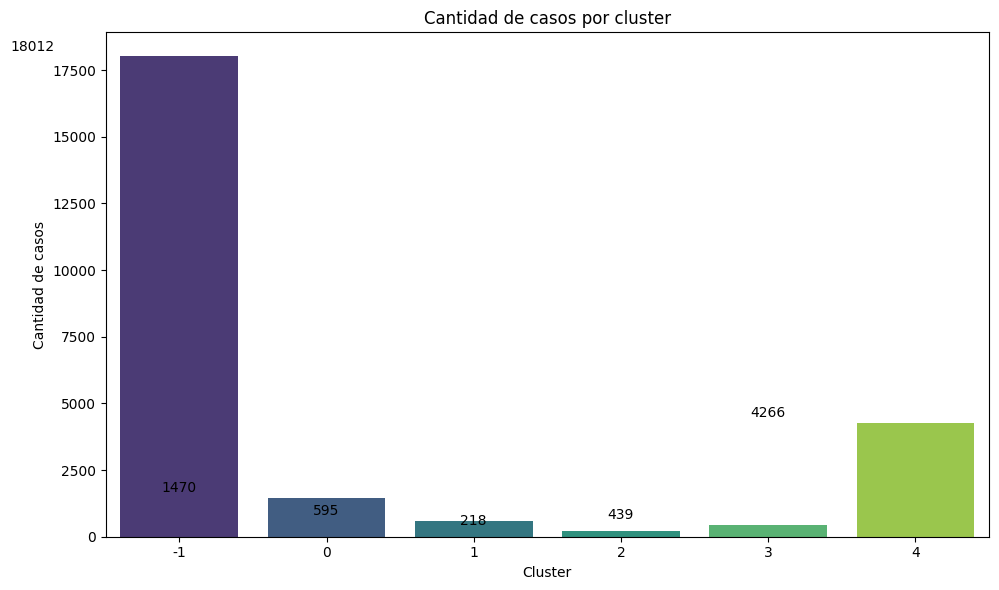

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()